In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import geopandas as gpd

In [10]:

df = pd.read_csv("pittsburghArrest.csv")

df = df[["AGE", "INCIDENTNEIGHBORHOOD"]]
df = df.dropna(subset=["AGE", "INCIDENTNEIGHBORHOOD"])
df["AGE"] = pd.to_numeric(df["AGE"], errors="coerce")
df = df.dropna(subset=["AGE"])

df["AGE_GROUP"] = df["AGE"].apply(lambda x: "<18" if x < 18 else "18+")

grouped = df.groupby(["INCIDENTNEIGHBORHOOD", "AGE_GROUP"]).size().unstack(fill_value=0)

grouped["Total_Count"] = grouped["<18"] + grouped["18+"]
grouped["Under_18_Percent_Local"] = grouped["<18"] / grouped["Total_Count"]
grouped["Over_18_Percent_Local"] = grouped["18+"] / grouped["Total_Count"]

total_under_18 = grouped["<18"].sum()
total_over_18 = grouped["18+"].sum()

grouped["Under_18_Percent_Global"] = grouped["<18"] / total_under_18
grouped["Over_18_Percent_Global"] = grouped["18+"] / total_over_18

result = grouped.reset_index().rename(columns={
    "INCIDENTNEIGHBORHOOD": "NEIGHBORHOOD",
    "<18": "Under_18_Count",
    "18+": "Over_18_Count"
})

result = result[
    ["NEIGHBORHOOD", "Under_18_Count", "Over_18_Count", "Total_Count",
     "Under_18_Percent_Local", "Over_18_Percent_Local",
     "Under_18_Percent_Global", "Over_18_Percent_Global"]
]

result.to_csv("summaryPittArrest.csv", index=False)


In [11]:
df = pd.read_csv("pittsburghParks.csv")


df = df[["type", "neighborhood"]]
df = df.dropna(subset=["type", "neighborhood"])


df["IS_PARK"] = df["type"].apply(lambda x: "Park" if x.strip().lower() == "park" else "Other")

grouped = df.groupby(["neighborhood", "IS_PARK"]).size().unstack(fill_value=0)

if "Park" not in grouped.columns:
    grouped["Park"] = 0
if "Other" not in grouped.columns:
    grouped["Other"] = 0

total_park = grouped["Park"].sum()
total_other = grouped["Other"].sum()

grouped["Park_Global_Percent"] = grouped["Park"] / total_park
grouped["Other_Global_Percent"] = grouped["Other"] / total_other

result = grouped.reset_index().rename(columns={
    "neighborhood": "NEIGHBORHOOD",
    "Park": "Park_Count",
    "Other": "Non_Park_Count"
})

result = result[
    ["NEIGHBORHOOD", "Park_Count", "Non_Park_Count", "Park_Global_Percent", "Other_Global_Percent"]
]

result.to_csv("summaryPittPark.csv", index=False)


In [12]:

df = pd.read_csv("pittsburghFacility.csv")

df = df[["type", "neighborhood"]]
df = df.dropna(subset=["type", "neighborhood"])

all_types = df["type"].unique()

pivot_table = df.groupby(["neighborhood", "type"]).size().unstack(fill_value=0)

type_totals = pivot_table.sum()

type_percents = pivot_table.divide(type_totals)

final_df = pivot_table.copy()
for col in pivot_table.columns:
    final_df[f"{col}_Count"] = pivot_table[col]
    final_df[f"{col}_Percent"] = type_percents[col]
    final_df.drop(columns=[col], inplace=True)
    
final_df["Total_Facilities"] = final_df[[col for col in final_df.columns if col.endswith("_Count")]].sum(axis=1)
final_df = final_df.reset_index().rename(columns={"neighborhood": "NEIGHBORHOOD"})

count_cols = [col for col in final_df.columns if col.endswith("_Count")]
percent_cols = [col for col in final_df.columns if col.endswith("_Percent")]
final_df = final_df[["NEIGHBORHOOD", "Total_Facilities"] + count_cols + percent_cols]

final_df.to_csv("summaryPittFacilities.csv", index=False)


In [13]:

df = pd.read_csv("pittsburghSteps.csv")

df = df[["neighborhood", "length", "number_of_steps"]]
df = df.dropna(subset=["neighborhood", "length", "number_of_steps"])

df_with_steps = df[df["number_of_steps"] > 0]
df_no_steps = df[df["number_of_steps"] == 0]

grouped_steps = df_with_steps.groupby("neighborhood").agg({
    "length": "sum",
    "number_of_steps": "sum"
}).rename(columns={
    "length": "Total_Length_With_Steps",
    "number_of_steps": "Total_Steps"
})

grouped_steps["Length_per_Step"] = grouped_steps["Total_Length_With_Steps"] / grouped_steps["Total_Steps"]

grouped_no_steps = df_no_steps.groupby("neighborhood").agg({
    "length": "sum"
}).rename(columns={"length": "Zero_Steps_Total_Length"})

final_df = grouped_steps.join(grouped_no_steps, how="outer").fillna(0)

final_df = final_df.reset_index().rename(columns={"neighborhood": "NEIGHBORHOOD"})

final_df.to_csv("summaryPittSteps.csv", index=False)

In [35]:
df = pd.read_csv("pittsburghTrees.csv")

tree_count = df.groupby("neighborhood").size().reset_index(name="tree_count")

tree_count.to_csv("summaryPittTrees.csv", index=False)

/var/folders/fj/3zw1wmsn6mzb929j8tmbz3340000gn/T/ipykernel_6584/1312813629.py:1: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("pittsburghTrees.csv")


In [36]:
import geopandas as gpd
import matplotlib.pyplot as plt

gdf = gpd.read_file("../GeopandasTest/hood.geojson")
# print(gdf["hood"].unique())
# print(gdf["Shape__Area"].head())
print(gdf.columns)

Index(['objectid', 'statefp10', 'countyfp10', 'tractce10', 'blkgrpce10',
       'geoid10', 'namelsad10', 'mtfcc10', 'funcstat10', 'aland10', 'awater10',
       'intptlat10', 'intptlon10', 'hood', 'hood_no', 'acres', 'sqmiles',
       'sectors', 'tract', 'cdbg2014', 'tracttext', 'objectid_1',
       'tractce10_1', 'cnt_tractce10', 'sum_lowmod2018', 'sum_lowmoduniv',
       'lowmodperct', 'lowmodpercanno', 'cdbg2018', 'Shape__Area',
       'Shape__Length', 'geometry'],
      dtype='object')


In [ ]:
# import pandas as pd

# arrest_df = pd.read_csv("summaryPittArrest.csv")
# park_df = pd.read_csv("summaryPittPark.csv")
# fac_df = pd.read_csv("summaryPittFacilities.csv")
# step_df = pd.read_csv("summaryPittSteps.csv")

# arrest_neigh = set(arrest_df["NEIGHBORHOOD"])
# fac_neigh = set(fac_df["NEIGHBORHOOD"])
# step_neigh = set(step_df["NEIGHBORHOOD"])
# park_neigh = set(park_df["NEIGHBORHOOD"])

# core_common = arrest_neigh & fac_neigh & step_neigh

# all_core = arrest_neigh | fac_neigh | step_neigh
# missing_core = all_core - core_common
# if missing_core:
#     print("The following neighborhood is missing in the dataset(Arrest/Facilities/Steps), and will not be counted:")
#     for name in sorted(missing_core):
#         print("-", name)

# arrest_df = arrest_df[arrest_df["NEIGHBORHOOD"].isin(core_common)]
# fac_df = fac_df[fac_df["NEIGHBORHOOD"].isin(core_common)]
# step_df = step_df[step_df["NEIGHBORHOOD"].isin(core_common)]

# park_df = park_df[park_df["NEIGHBORHOOD"].isin(core_common)]

# merged = arrest_df.merge(fac_df, on="NEIGHBORHOOD")
# merged = merged.merge(step_df, on="NEIGHBORHOOD")
# merged = merged.merge(park_df, on="NEIGHBORHOOD", how="left")

# merged = merged.fillna(0)

# merged.to_csv("summaryPitt_ALL_MERGED.csv", index=False)


The following neighborhood is missing in the dataset(Arrest/Facilities/Steps), and will not be counted:
- Allegheny West
- Arlington
- Arlington Heights
- Central North Side
- Chartiers City
- Chateau
- East Carnegie
- Esplen
- Fairywood
- Friendship
- Golden Triangle/Civic Arena
- Hays
- Homewood South
- Homewood West
- Mount Oliver
- Mount Oliver Borough
- Mt. Oliver
- Mt. Oliver Boro
- Mt. Oliver Neighborhood
- New Homestead
- North Shore
- Northview Heights
- Outside City
- Outside County
- Outside State
- Ridgemont
- South Shore
- Spring Garden
- St. Clair
- Summer Hill
- Swisshelm Park
- Troy Hill-Herrs Island


In [2]:
arrest_df = pd.read_csv("summaryPittArrest.csv")
park_df = pd.read_csv("summaryPittPark.csv")
facilities_df = pd.read_csv("summaryPittFacilities.csv")
steps_df = pd.read_csv("summaryPittSteps.csv")
trees_df = pd.read_csv("summaryPittTrees.csv")

geo = gpd.read_file("hood.geojson")
area_df = geo[["hood", "Shape__Area"]].copy()
area_df.rename(columns={"hood": "NEIGHBORHOOD"}, inplace=True)

merged = arrest_df.merge(park_df, on="NEIGHBORHOOD", how="left")
merged.fillna(0, inplace=True)

merged = merged.merge(facilities_df, on="NEIGHBORHOOD", how="inner")
merged = merged.merge(steps_df, on="NEIGHBORHOOD", how="inner")
merged = merged.merge(trees_df, on="NEIGHBORHOOD", how="inner")

neighborhoods_sets = {
    "Arrest": set(arrest_df["NEIGHBORHOOD"]),
    "Park": set(park_df["NEIGHBORHOOD"]),
    "Facilities": set(facilities_df["NEIGHBORHOOD"]),
    "Steps": set(steps_df["NEIGHBORHOOD"]),
    "Trees": set(trees_df["NEIGHBORHOOD"]),
}
common_neighborhoods = set(merged["NEIGHBORHOOD"])
for name, original in neighborhoods_sets.items():
    if name == "Park": continue
    missing = original - common_neighborhoods
    if missing:
        print(f"The following neighborhood is missing in the dataset(Arrest/Facilities/Steps), and will not be counted: {name}", missing)

merged = merged.merge(area_df, on="NEIGHBORHOOD", how="inner")

unit_columns = []
for col in merged.columns:
    if col not in ["NEIGHBORHOOD", "Shape__Area"]:
        unit_col = col + "_unit"
        merged[unit_col] = merged[col] / merged["Shape__Area"]
        unit_columns.append(unit_col)

ordered_cols = ["NEIGHBORHOOD"] + unit_columns + [col for col in merged.columns if col not in ["neighborhood", "Shape__Area"] + unit_columns]
final_df = merged[ordered_cols]

final_df.to_csv("summaryPitt_ALL_MERGED_UNIT.csv", index=False)


The following neighborhood is missing in the dataset(Arrest/Facilities/Steps), and will not be counted: Arrest {'Mt. Oliver Neighborhood', 'Arlington Heights', 'Arlington', 'Esplen', 'Homewood South', 'Homewood West', 'Troy Hill-Herrs Island', 'Outside State', 'Fairywood', 'North Shore', 'Northview Heights', 'New Homestead', 'Chartiers City', 'Spring Garden', 'St. Clair', 'Mount Oliver', 'Mt. Oliver Boro', 'Allegheny West', 'East Carnegie', 'Outside City', 'Hays', 'Central North Side', 'Swisshelm Park', 'Golden Triangle/Civic Arena', 'Summer Hill', 'South Shore', 'Chateau', 'Friendship', 'Ridgemont', 'Outside County'}
The following neighborhood is missing in the dataset(Arrest/Facilities/Steps), and will not be counted: Facilities {'Allegheny West', 'Swisshelm Park', 'Fairywood', 'Chateau', 'Homewood South', 'Homewood West', 'Hays'}
The following neighborhood is missing in the dataset(Arrest/Facilities/Steps), and will not be counted: Steps {'Mt. Oliver', 'Mount Oliver Borough', 'North

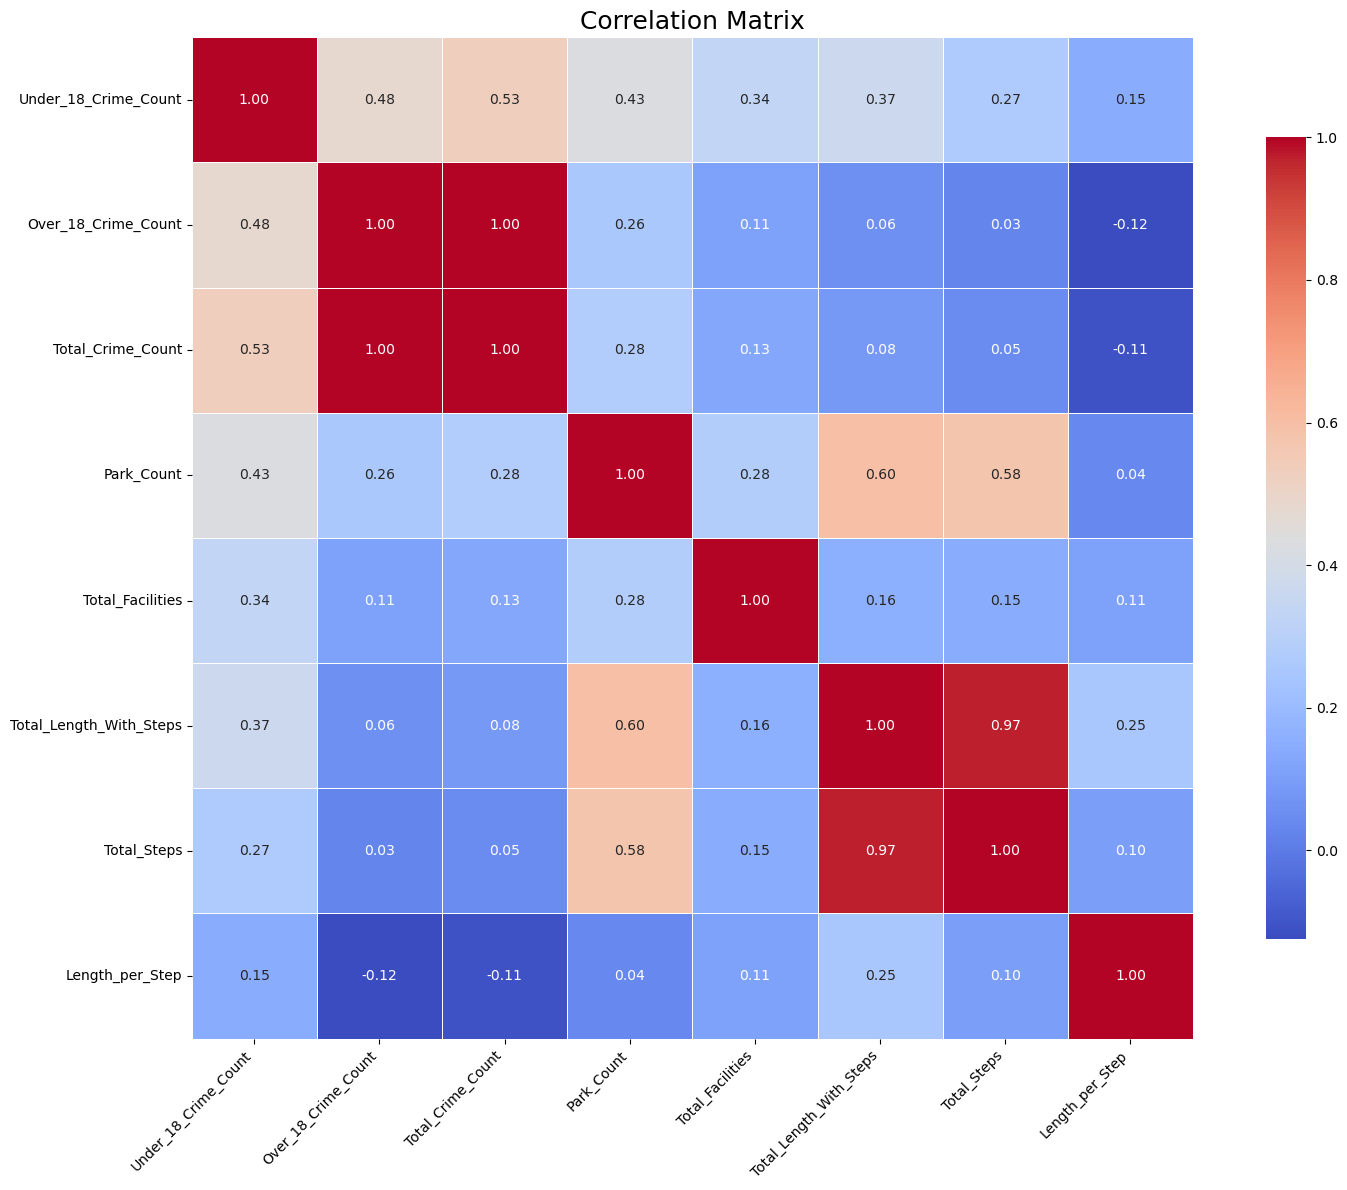

In [33]:
df = pd.read_csv("summaryPitt_ALL_MERGED.csv")

columns_to_analyze = [
    "Under_18_Crime_Count", "Over_18_Crime_Count",
    "Total_Crime_Count",
    "Park_Count",
    # "Park", "Not_Park", "Park_Global_Percent", "Not_Park_Global_Percent",

    "Total_Facilities",

    "Total_Length_With_Steps", "Total_Steps", "Length_per_Step"
    # , "Zero_Steps_Total_Length",
]

correlation_matrix = df[columns_to_analyze].corr()

plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True,
            linewidths=.5, cbar_kws={"shrink": .8})

plt.title("Correlation Matrix", fontsize=18)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()

plt.savefig("correlation_matrix.png", dpi=300)
plt.show()

/var/folders/fj/3zw1wmsn6mzb929j8tmbz3340000gn/T/ipykernel_6584/3760352023.py:26: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/fj/3zw1wmsn6mzb929j8tmbz3340000gn/T/ipykernel_6584/3760352023.py:26: UserWarning: Glyph 25152 (\N{CJK UNIFIED IDEOGRAPH-6240}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/fj/3zw1wmsn6mzb929j8tmbz3340000gn/T/ipykernel_6584/3760352023.py:26: UserWarning: Glyph 26377 (\N{CJK UNIFIED IDEOGRAPH-6709}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/fj/3zw1wmsn6mzb929j8tmbz3340000gn/T/ipykernel_6584/3760352023.py:26: UserWarning: Glyph 21464 (\N{CJK UNIFIED IDEOGRAPH-53D8}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/fj/3zw1wmsn6mzb929j8tmbz3340000gn/T/ipykernel_6584/3760352023.py:26: UserWarning: Glyph 37327 (\N{CJK UNIFIED IDEOGRAPH-91CF}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/fj/3zw1wmsn6mzb929j8tmbz3340

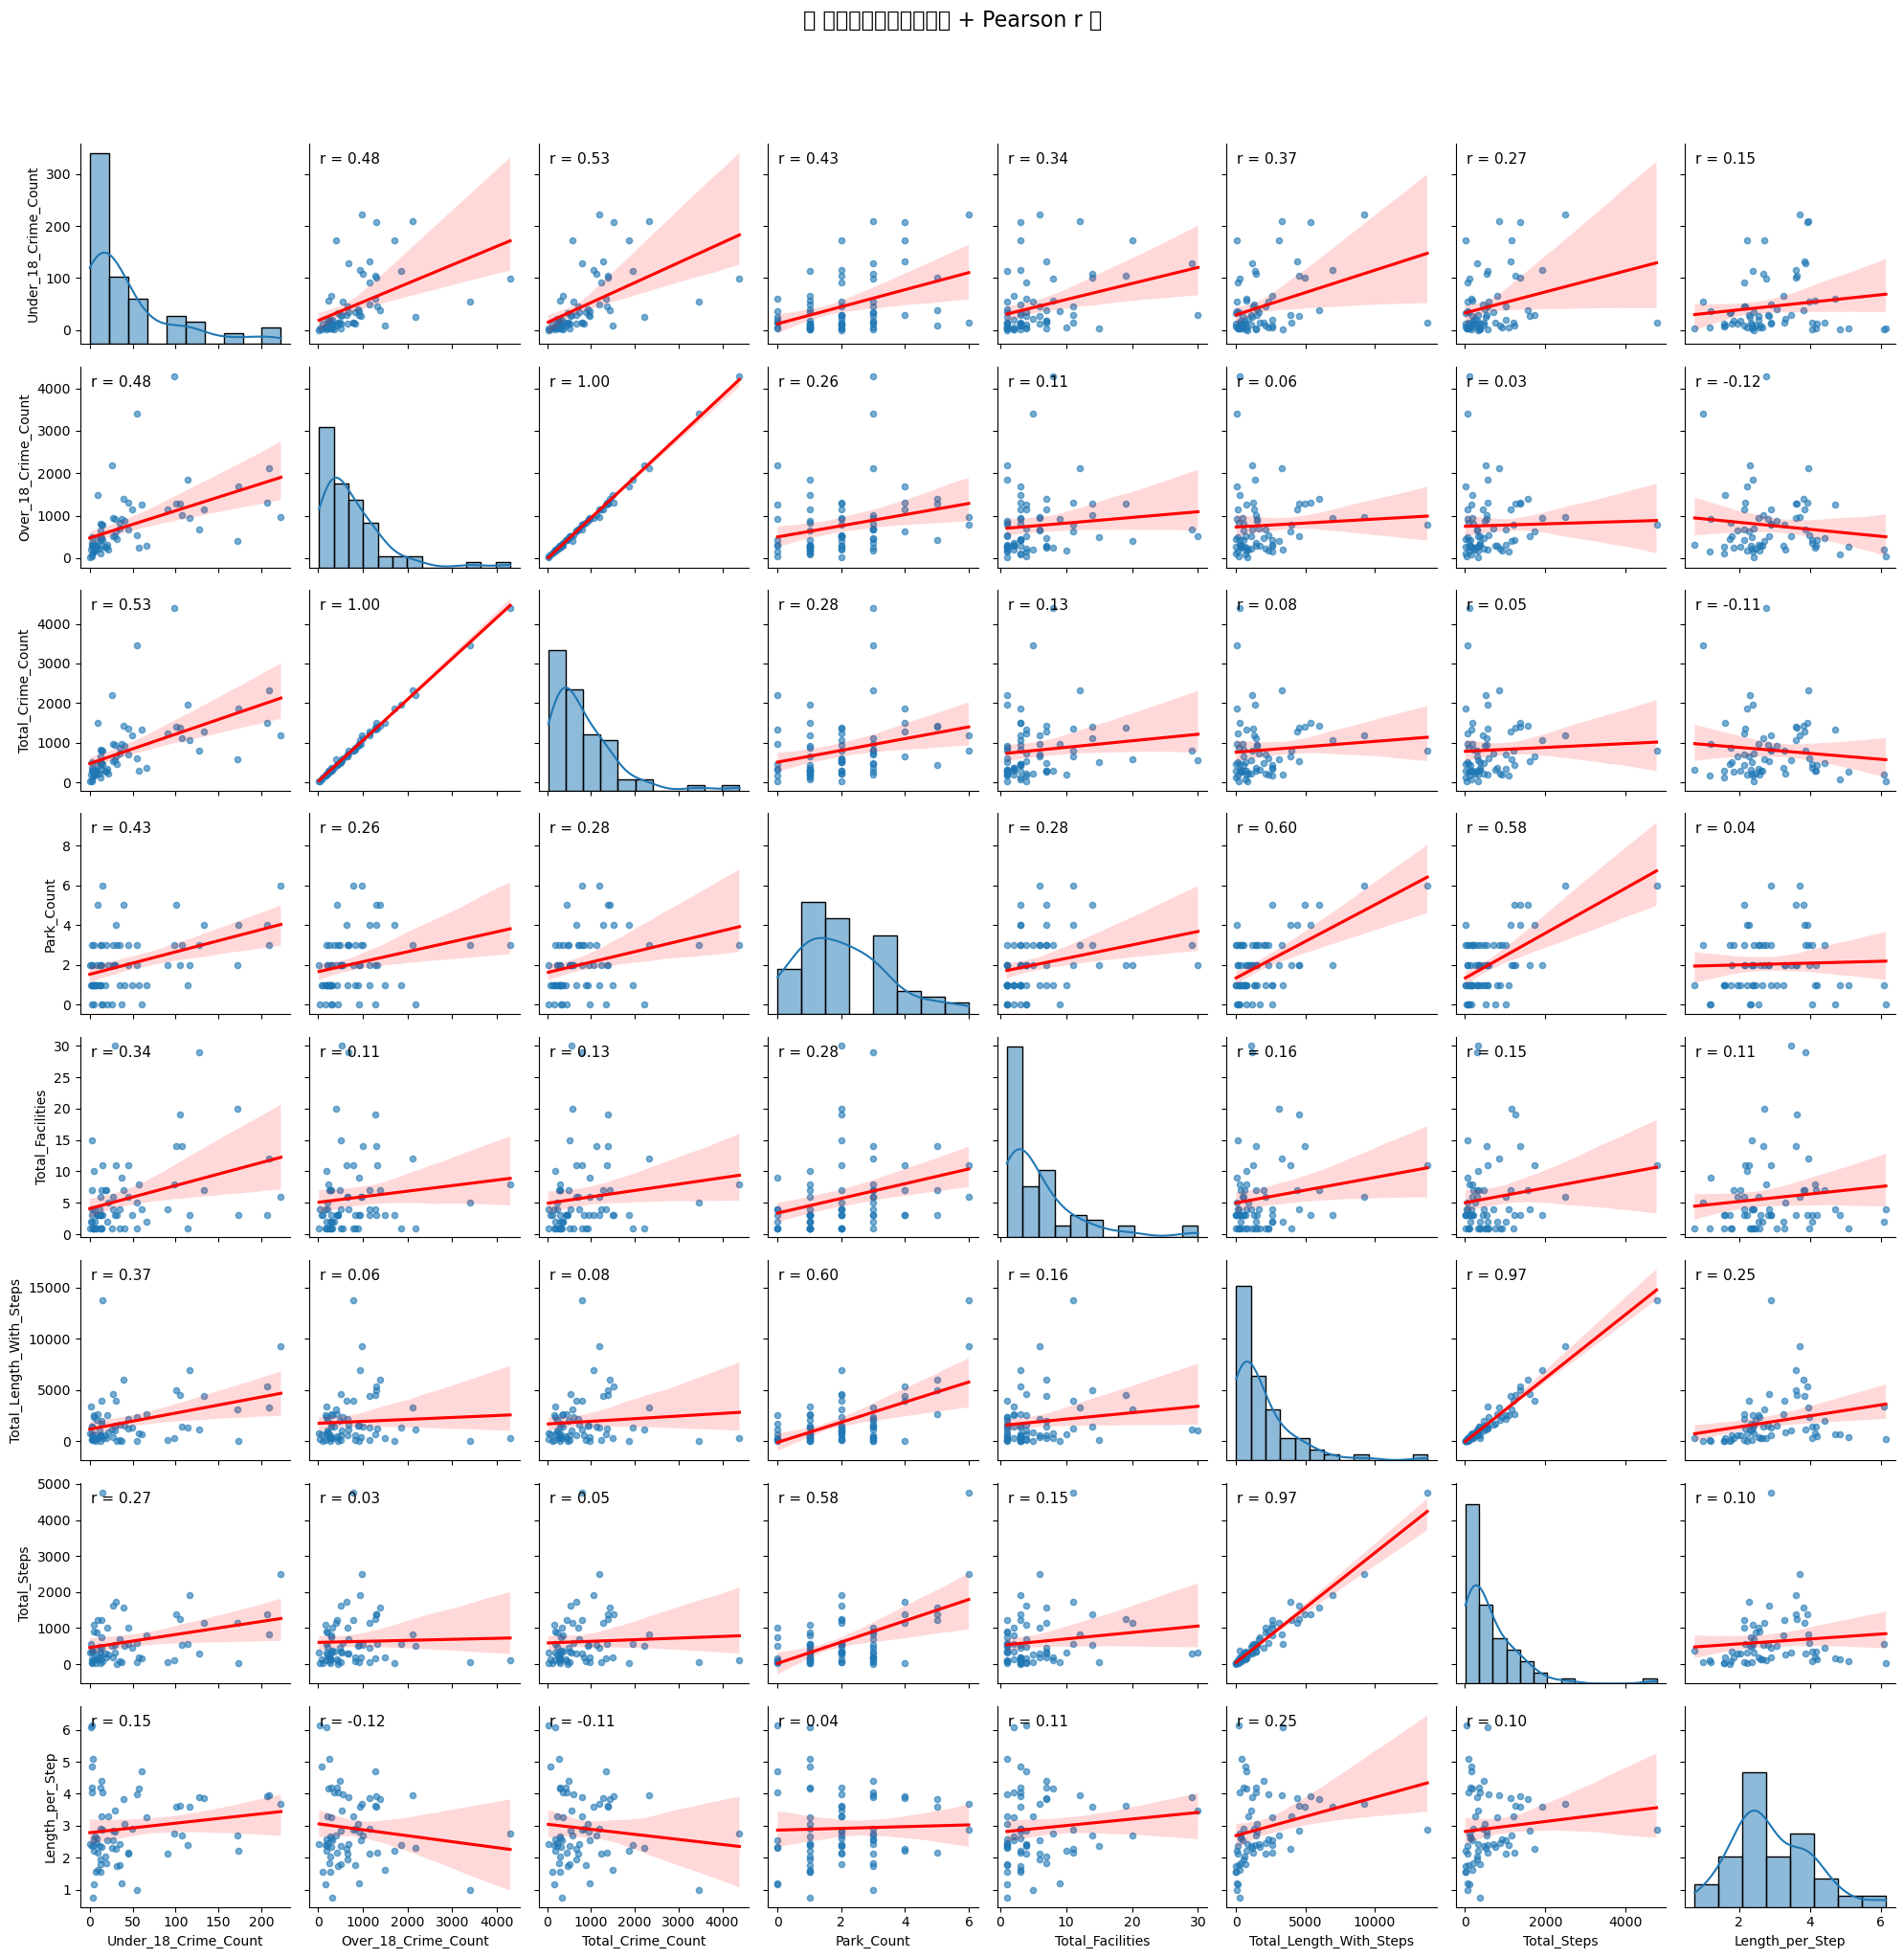

In [34]:
data = df[columns_to_analyze].copy()

# --- 定义一个带 r 值的回归图函数 ---
def regplot_with_r(x, y, **kwargs):
    ax = kwargs.get("ax", plt.gca())
    sns.regplot(x=x, y=y, ax=ax,
                scatter_kws={"s": 20, "alpha": 0.6},
                line_kws={"color": "red"})
    # 计算 r 值
    r, _ = pearsonr(x, y)
    ax.annotate(f"r = {r:.2f}", xy=(0.05, 0.9), xycoords='axes fraction',
                fontsize=11, color='black')

# --- 创建 PairGrid ---
g = sns.PairGrid(data, height=2.5)

# 左下角和右上角都用 regplot_with_r
g.map_lower(regplot_with_r)
g.map_upper(regplot_with_r)

# 对角线画分布图
g.map_diag(sns.histplot, kde=True)

# 标题 & 美化
plt.suptitle("📊 所有变量两两线性拟合 + Pearson r 值", fontsize=16, y=1.02)
plt.tight_layout()
plt.subplots_adjust(top=0.95)  # 给标题留空间
plt.savefig("pairwise_full_regplot_r.png", dpi=300)
plt.show()